In [1]:
import pandas as pd
import numpy as np
import os
import glob
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import timedelta

In [ ]:
# Data path where all daily CSV files are stored
data_directory = 'D:/Backblaze_Data/data_Q2_2024/Training-Q1-data/'  # Replace with your data directory path

# Number of days before failure to include (excluding the failure day)
days_before_failure = 30  # You can change this value

# Length of each sequence (number of past days)
sequence_length = 30  # You can change this value

# List of SMART attribute numbers to include
smart_attribute_numbers = [
    5, 187, 197, 198
]

# smart_attribute_numbers = [
#     194, 12, 9, 1, 192, 199, 5, 198, 10, 3, 7, 193, 197, 240, 196, 2, 8, 241, 242, 187, 188, 190
# ]

# Whether to include 'raw', 'normalized', or both versions
include_raw = True
include_normalized = True

# Training parameters
num_epochs = 10  # Adjust as needed
batch_size = 64
learning_rate = 0.001
k_folds = 5

# Device configuration (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Generate the list of SMART attribute column names
smart_attributes = []

for num in smart_attribute_numbers:
    if include_raw:
        smart_attributes.append(f'smart_{num}_raw')
    if include_normalized:
        smart_attributes.append(f'smart_{num}_normalized')

print('SMART Attributes to be included:', smart_attributes)

SMART Attributes to be included: ['smart_5_raw', 'smart_5_normalized', 'smart_187_raw', 'smart_187_normalized', 'smart_197_raw', 'smart_197_normalized', 'smart_198_raw', 'smart_198_normalized']


In [4]:
# Initialize an empty list to store failure records
failure_records = []

# Get a list of all CSV files in the directory
all_files = glob.glob(os.path.join(data_directory, '*.csv'))
all_files.sort()  # Ensure files are processed in order

# Iterate over each file to collect failure records
for filename in all_files:
    df = pd.read_csv(filename, usecols=['date', 'serial_number', 'failure'])
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    # Filter rows where failure == 1
    failures = df[df['failure'] == 1]
    if not failures.empty:
        failure_records.append(failures)

# Concatenate all failure records into a single dataframe
failure_data = pd.concat(failure_records, ignore_index=True)

# Get the list of failed drives and their failure dates
failed_drives_info = failure_data.groupby('serial_number')['date'].max().reset_index()
failed_drives_info.rename(columns={'date': 'failure_date'}, inplace=True)

print(f"Number of failed drives: {len(failed_drives_info)}")

Number of failed drives: 978


In [5]:
from collections import defaultdict

# Dictionary to hold data for each failed drive
failed_drives_data = defaultdict(list)

# Convert failed_drives_info to a dictionary for quick access
failure_date_dict = failed_drives_info.set_index('serial_number')['failure_date'].to_dict()

# Columns to read from each CSV file
columns_to_read = ['date', 'serial_number', 'model'] + smart_attributes + ['failure']

# Iterate over each file to collect data for failed drives
for filename in all_files:
    df = pd.read_csv(filename, usecols=columns_to_read)
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    # Filter rows for failed drives
    df_failed = df[df['serial_number'].isin(failure_date_dict.keys())]
    if df_failed.empty:
        continue  # Skip if no failed drives are present in this file
    # Append data to failed_drives_data
    for serial_number, group in df_failed.groupby('serial_number'):
        failed_drives_data[serial_number].append(group)

In [6]:
# Initialize an empty list to store filtered data
filtered_data_list = []

for serial_number, data_list in failed_drives_data.items():
    # Concatenate data for this drive
    drive_data = pd.concat(data_list, ignore_index=True)
    # Get the failure date
    failure_date = failure_date_dict[serial_number]
    # Ensure dates are date-only (remove time components)
    failure_date = failure_date.normalize()
    drive_data['date'] = drive_data['date'].dt.normalize()
    # Filter data within the desired date range
    start_date = failure_date - pd.Timedelta(days=days_before_failure)
    drive_data = drive_data[(drive_data['date'] >= start_date) & (drive_data['date'] <= failure_date)]
    # Calculate days_until_failure
    drive_data['days_until_failure'] = (failure_date - drive_data['date']).dt.days
    # Keep only dates where days_until_failure is between 0 and days_before_failure
    drive_data = drive_data[(drive_data['days_until_failure'] >= 0) & (drive_data['days_until_failure'] <= days_before_failure)]
    # Append to the list
    filtered_data_list.append(drive_data)

# Concatenate all filtered data
filtered_data = pd.concat(filtered_data_list, ignore_index=True)

In [7]:
# Encode the model types
le = LabelEncoder()
filtered_data['model_encoded'] = le.fit_transform(filtered_data['model'])

# Sort data by serial_number and date
filtered_data.sort_values(by=['serial_number', 'date'], inplace=True)

# Reset index
filtered_data.reset_index(drop=True, inplace=True)

In [8]:
# Get the mapping from model names to their encoded numbers
model_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Get the counts of samples per model in the filtered data
model_counts = filtered_data['model'].value_counts()

print("\nNumber of Samples per Model:")
for model_name, count in model_counts.items():
    encoded_number = model_mapping[model_name]
    print(f"Model Name: {model_name}, Encoded Number: {encoded_number}, Number of Samples: {count}")


Number of Samples per Model:
Model Name: ST12000NM0008, Encoded Number: 8, Number of Samples: 2636
Model Name: TOSHIBA MG07ACA14TA, Encoded Number: 24, Number of Samples: 1829
Model Name: HGST HUH721212ALN604, Encoded Number: 4, Number of Samples: 1702
Model Name: TOSHIBA MG08ACA16TA, Encoded Number: 26, Number of Samples: 1435
Model Name: ST8000NM0055, Encoded Number: 20, Number of Samples: 1433
Model Name: HGST HUH721212ALE604, Encoded Number: 3, Number of Samples: 1193
Model Name: ST4000DM000, Encoded Number: 16, Number of Samples: 1070
Model Name: ST16000NM001G, Encoded Number: 14, Number of Samples: 877
Model Name: ST12000NM001G, Encoded Number: 10, Number of Samples: 764
Model Name: ST14000NM001G, Encoded Number: 12, Number of Samples: 733
Model Name: ST12000NM0007, Encoded Number: 7, Number of Samples: 682
Model Name: ST8000DM002, Encoded Number: 19, Number of Samples: 642
Model Name: ST14000NM0138, Encoded Number: 13, Number of Samples: 339
Model Name: WDC WUH721816ALE6L4, Enc

In [9]:
# Set the option and threshold
remove_models_with_few_samples = True  # Set to True or False
min_samples_per_model = 60  # Minimum number of samples required per model

if remove_models_with_few_samples:
    # Identify models with samples less than the threshold
    models_to_keep = model_counts[model_counts >= min_samples_per_model].index.tolist()
    models_to_remove = model_counts[model_counts < min_samples_per_model].index.tolist()
    
    print(f"\nRemoving models with fewer than {min_samples_per_model} samples:")
    for model_name in models_to_remove:
        encoded_number = model_mapping[model_name]
        count = model_counts[model_name]
        print(f"Model Name: {model_name}, Encoded Number: {encoded_number}, Number of Samples: {count}")
    
    # Filter out entries of models to remove
    filtered_data = filtered_data[filtered_data['model'].isin(models_to_keep)].reset_index(drop=True)
    
    # Re-encode model types after removal
    le = LabelEncoder()
    filtered_data['model_encoded'] = le.fit_transform(filtered_data['model'])
    
    # Update model mapping
    model_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # Update model counts
    model_counts = filtered_data['model'].value_counts()
    
    print("\nUpdated Model Name to Encoded Number Mapping:")
    for model_name, encoded_number in model_mapping.items():
        print(f"Model Name: {model_name}, Encoded Number: {encoded_number}")
    
    print("\nUpdated Number of Samples per Model:")
    for model_name, count in model_counts.items():
        encoded_number = model_mapping[model_name]
        print(f"Model Name: {model_name}, Encoded Number: {encoded_number}, Number of Samples: {count}")


Removing models with fewer than 60 samples:
Model Name: TOSHIBA MG07ACA14TEY, Encoded Number: 25, Number of Samples: 54
Model Name: HGST HUH721212ALE600, Encoded Number: 2, Number of Samples: 52
Model Name: HGST HUH728080ALE600, Encoded Number: 5, Number of Samples: 42
Model Name: HGST HMS5C4040ALE640, Encoded Number: 0, Number of Samples: 35
Model Name: ST500LM030, Encoded Number: 18, Number of Samples: 30
Model Name: ST14000NM000J, Encoded Number: 11, Number of Samples: 29
Model Name: TOSHIBA HDWF180, Encoded Number: 23, Number of Samples: 21
Model Name: Seagate BarraCuda SSD ZA250CM10002, Encoded Number: 22, Number of Samples: 21
Model Name: ST18000NM000J, Encoded Number: 15, Number of Samples: 21
Model Name: ST12000NM000J, Encoded Number: 9, Number of Samples: 16
Model Name: Seagate BarraCuda 120 SSD ZA250CM10003, Encoded Number: 21, Number of Samples: 4

Updated Model Name to Encoded Number Mapping:
Model Name: HGST HMS5C4040BLE640, Encoded Number: 0
Model Name: HGST HUH721212ALE

In [10]:
enable_bfill = False

# Initialize lists for features and labels
X = []
y = []

# Group data by serial_number
grouped = filtered_data.groupby('serial_number')

for name, group in grouped:
    # Ensure the group is sorted by date
    group = group.sort_values(by='date').reset_index(drop=True)
    # Create a dictionary mapping dates to SMART attributes and model_encoded
    date_to_data = group.set_index('date').to_dict('index')
    # Get a list of dates for which we want to create sequences
    dates = group['date'].unique()
    failure_date = failure_date_dict[name].normalize()
    for current_date in dates:
        days_until_failure = (failure_date - current_date).days
        if days_until_failure < 0 or days_until_failure > days_before_failure:
            continue  # Skip dates outside the desired range
        # Build the sequence of dates for the sequence_length
        sequence_dates = [current_date - pd.Timedelta(days=i) for i in range(sequence_length - 1, -1, -1)]
        # Collect SMART attribute sequences
        sequence_records = []
        for seq_date in sequence_dates:
            if seq_date in date_to_data:
                seq_record = date_to_data[seq_date]
                # Collect SMART attributes
                smart_values = {attr: seq_record.get(attr, np.nan) for attr in smart_attributes}
            else:
                # If data for the date is missing, append NaNs
                smart_values = {attr: np.nan for attr in smart_attributes}
            smart_values['date'] = seq_date
            sequence_records.append(smart_values)
        # Create the DataFrame once
        sequence_df = pd.DataFrame(sequence_records)
        # Sort by date
        sequence_df.sort_values(by='date', inplace=True)
        # Check missing values
        missing_count = sequence_df[smart_attributes].isna().sum().sum()
        total_values = sequence_length * len(smart_attributes)
        if missing_count > total_values / 2:
            continue  # Discard this data point
        # Handle missing values with forward filling
        sequence_df[smart_attributes] = sequence_df[smart_attributes].ffill()
        # Handle missing values with backward filling if enable
        if enable_bfill:
            sequence_df[smart_attributes] = sequence_df[smart_attributes].bfill()
        # If any remaining NaNs (e.g., at the start), fill with zeros
        sequence_df[smart_attributes] = sequence_df[smart_attributes].fillna(0)
        # Flatten the sequence data
        sequence_data = sequence_df[smart_attributes].values.flatten()
        # Prepend model_encoded to the features
        model_encoded = date_to_data[current_date]['model_encoded']
        features = [model_encoded] + sequence_data.tolist()
        X.append(features)
        y.append(days_until_failure)

Label Distribution:
Days Until Failure 0: 815 samples
Days Until Failure 1: 784 samples
Days Until Failure 2: 762 samples
Days Until Failure 3: 743 samples
Days Until Failure 4: 732 samples
Days Until Failure 5: 731 samples
Days Until Failure 6: 723 samples
Days Until Failure 7: 712 samples
Days Until Failure 8: 400 samples
Days Until Failure 9: 397 samples
Days Until Failure 10: 389 samples
Days Until Failure 11: 384 samples


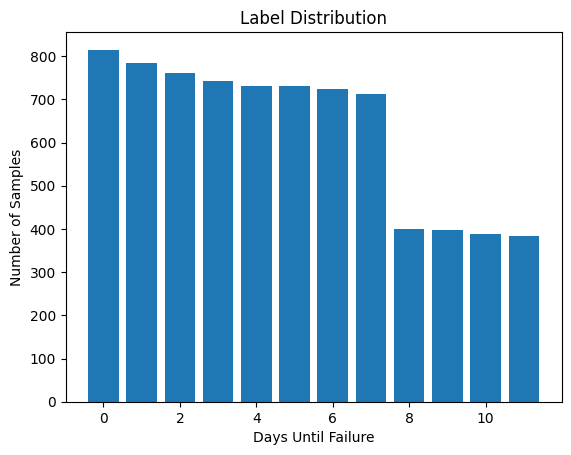

In [11]:
# Convert labels to NumPy array
y = np.array(y)

# Display unique labels and their counts
unique_labels, counts = np.unique(y, return_counts=True)
label_distribution = dict(zip(unique_labels, counts))
print("Label Distribution:")
for label, count in label_distribution.items():
    print(f"Days Until Failure {int(label)}: {count} samples")

# Optionally, plot the label distribution
plt.bar(label_distribution.keys(), label_distribution.values())
plt.xlabel('Days Until Failure')
plt.ylabel('Number of Samples')
plt.title('Label Distribution')
plt.show()

In [12]:
# Convert features to NumPy array
X = np.array(X)

# Normalize SMART attributes (Optional but recommended)
# Exclude model_encoded (first column)
scaler = StandardScaler()
X[:, 1:] = scaler.fit_transform(X[:, 1:])

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # For regression

# Verify the contents of y_tensor
print("Unique labels in y_tensor:", torch.unique(y_tensor))
print("Sample labels in y_tensor:", y_tensor[:10].flatten())

Unique labels in y_tensor: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
Sample labels in y_tensor: tensor([7., 6., 5., 4., 3., 2., 1., 0., 3., 2.])


In [13]:
# Create dataset
dataset = TensorDataset(X_tensor, y_tensor)

In [14]:
import random
from IPython.display import display, clear_output
import ipywidgets as widgets

# Invert the LabelEncoder to get the mapping from encoded labels to model names
model_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# Function to preview a random sample
def preview_random_sample():
    # Randomly select an index
    idx = random.randint(0, len(X) - 1)
    
    # Get the feature vector and label
    feature_vector_scaled = X[idx]
    label = y[idx]
    
    # Extract model_encoded and get the model name
    model_encoded = int(feature_vector_scaled[0])
    model_name = model_mapping.get(model_encoded, 'Unknown Model')
    
    # Extract the scaled SMART attribute sequences
    sequence_data_scaled = feature_vector_scaled[1:]  # Exclude model_encoded
    num_attributes = len(smart_attributes)
    
    # Reshape the sequence data to (1, sequence_length * num_attributes)
    sequence_data_scaled = sequence_data_scaled.reshape(1, -1)
    
    # Inverse transform the scaled SMART attributes to get original values
    sequence_data_original = scaler.inverse_transform(sequence_data_scaled)
    
    # Reshape back to (sequence_length, num_attributes)
    sequence_array_original = sequence_data_original.reshape(sequence_length, num_attributes)
    
    # Create a DataFrame for display
    sequence_df = pd.DataFrame(sequence_array_original, columns=smart_attributes)
    sequence_df['Time Step'] = range(1, sequence_length + 1)  # Normal time steps from 1 to 20
    sequence_df = sequence_df[['Time Step'] + smart_attributes]
    
    # Clear previous output and display the new sample
    clear_output(wait=True)
    print(f"\nSample Index: {idx}")
    print(f"Model Name: {model_name}")
    print(f"Label (Days Until Failure): {int(label)}")
    print("SMART Attribute Sequences (Original Values, sorted by time):")
    print(sequence_df.to_string(index=False))
    
    # Plot each SMART attribute over time with 3 graphs per row
    num_plots = len(smart_attributes)
    fig, axes = plt.subplots(nrows=(num_plots // 3) + (num_plots % 3 > 0), ncols=3, figsize=(15, (num_plots // 3) * 5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, attr in enumerate(smart_attributes):
        ax = axes[i]
        ax.plot(sequence_df['Time Step'], sequence_df[attr], marker='o')
        ax.set_title(f"{attr} over Time")
        ax.set_xlabel('Time Step')
        ax.set_ylabel(attr)
        ax.grid(True)
        ax.set_xticks(sequence_df['Time Step'])
        ax.set_xticklabels(sequence_df['Time Step'])
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=2)  # Adjust spacing between plots
    plt.show()

# Button widget to refresh and preview a new sample
refresh_button = widgets.Button(description="Refresh Sample")
output = widgets.Output()

def on_button_click(b):
    with output:
        preview_random_sample()

refresh_button.on_click(on_button_click)

# Display the button and output
display(refresh_button, output)

# Automatically trigger the first preview
on_button_click(None)

Button(description='Refresh Sample', style=ButtonStyle())

Output()

In [15]:
import torch.nn.functional as F
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size):
        super(FullyConnectedNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [16]:
input_size = X.shape[1]

In [17]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest a value for the learning rate
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    
    # Prepare K-fold cross-validation
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    # For storing the results
    results = {}
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        # Create data loaders for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
        
        # Initialize the model
        model = FullyConnectedNet(input_size).to(device)
        
        # Define loss and optimizer with the suggested learning rate
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                # Backward and optimize
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        
        # Evaluation on the validation set
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_X)
                all_preds.extend(outputs.cpu().numpy().flatten())
                all_labels.extend(batch_y.cpu().numpy().flatten())
        
        # Compute MAE and RMSE
        mae = mean_absolute_error(all_labels, all_preds)
        rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
        results[fold] = {'MAE': mae, 'RMSE': rmse}
    
    # Compute average MAE across folds
    avg_mae = np.mean([results[fold]['MAE'] for fold in results])
    
    return avg_mae  # Return the average MAE as the objective value

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-11-14 14:19:44,325] A new study created in memory with name: no-name-adc081ce-43e2-4347-8501-a45d2f7282ed
[I 2024-11-14 14:20:05,257] Trial 0 finished with value: 0.5730490684509277 and parameters: {'lr': 0.00023262831040418263}. Best is trial 0 with value: 0.5730490684509277.
[I 2024-11-14 14:20:24,826] Trial 1 finished with value: 0.6525474786758423 and parameters: {'lr': 4.1699270386126576e-05}. Best is trial 0 with value: 0.5730490684509277.
[I 2024-11-14 14:20:45,510] Trial 2 finished with value: 0.7487313747406006 and parameters: {'lr': 0.0016767533983579623}. Best is trial 0 with value: 0.5730490684509277.
[I 2024-11-14 14:21:07,992] Trial 3 finished with value: 0.6479794383049011 and parameters: {'lr': 0.01279883158879019}. Best is trial 0 with value: 0.5730490684509277.
[I 2024-11-14 14:21:27,787] Trial 4 finished with value: 1.393244743347168 and parameters: {'lr': 1.0883867116344033e-05}. Best is trial 0 with value: 0.5730490684509277.
[I 2024-11-14 14:21:50,874] Tri

Best learning rate found: 0.0001337254351792403

Fold 1/5
Epoch [1/10], Loss: 19.3714
Epoch [2/10], Loss: 2.4224
Epoch [3/10], Loss: 1.6439
Epoch [4/10], Loss: 1.4949
Epoch [5/10], Loss: 1.4270
Epoch [6/10], Loss: 1.3936
Epoch [7/10], Loss: 1.3894
Epoch [8/10], Loss: 1.3884
Epoch [9/10], Loss: 1.3747
Epoch [10/10], Loss: 1.3478
Validation MAE for fold 1: 0.52
Validation RMSE for fold 1: 1.20


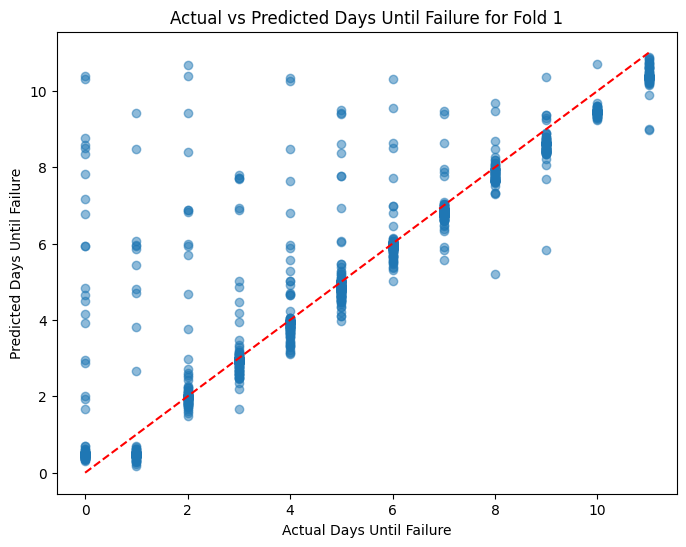

--------------------------------

Fold 2/5
Epoch [1/10], Loss: 16.6627
Epoch [2/10], Loss: 2.4195
Epoch [3/10], Loss: 1.6484
Epoch [4/10], Loss: 1.4969
Epoch [5/10], Loss: 1.4318
Epoch [6/10], Loss: 1.3800
Epoch [7/10], Loss: 1.3735
Epoch [8/10], Loss: 1.3664
Epoch [9/10], Loss: 1.3584
Epoch [10/10], Loss: 1.3370
Validation MAE for fold 2: 0.49
Validation RMSE for fold 2: 1.24


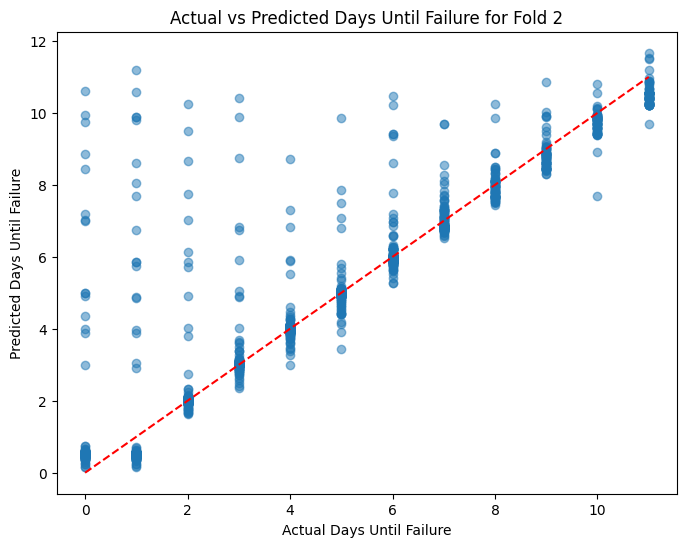

--------------------------------

Fold 3/5
Epoch [1/10], Loss: 19.5975
Epoch [2/10], Loss: 2.5048
Epoch [3/10], Loss: 1.6947
Epoch [4/10], Loss: 1.5475
Epoch [5/10], Loss: 1.4886
Epoch [6/10], Loss: 1.4541
Epoch [7/10], Loss: 1.4297
Epoch [8/10], Loss: 1.4097
Epoch [9/10], Loss: 1.3935
Epoch [10/10], Loss: 1.3930
Validation MAE for fold 3: 0.66
Validation RMSE for fold 3: 1.15


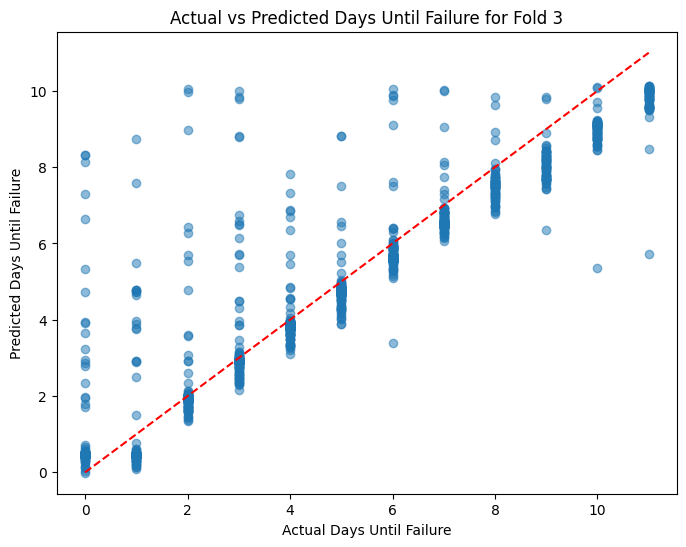

--------------------------------

Fold 4/5
Epoch [1/10], Loss: 18.5368
Epoch [2/10], Loss: 2.5073
Epoch [3/10], Loss: 1.7288
Epoch [4/10], Loss: 1.6123
Epoch [5/10], Loss: 1.5427
Epoch [6/10], Loss: 1.5430
Epoch [7/10], Loss: 1.4714
Epoch [8/10], Loss: 1.4797
Epoch [9/10], Loss: 1.4698
Epoch [10/10], Loss: 1.4417
Validation MAE for fold 4: 0.52
Validation RMSE for fold 4: 1.03


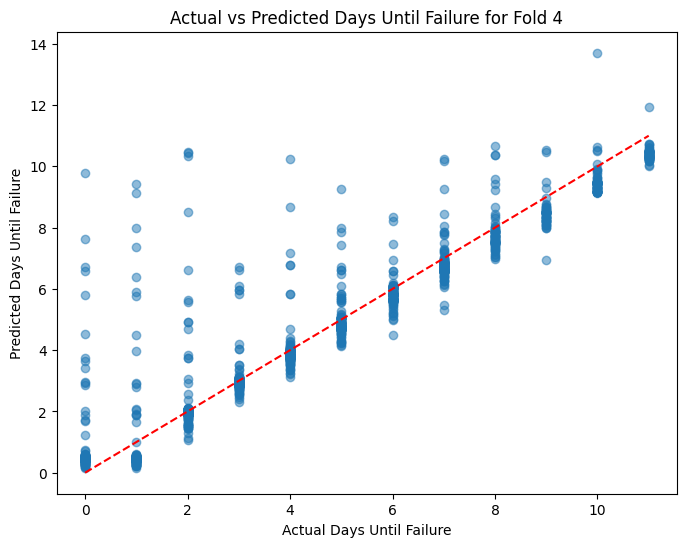

--------------------------------

Fold 5/5
Epoch [1/10], Loss: 19.5348
Epoch [2/10], Loss: 2.5568
Epoch [3/10], Loss: 1.5914
Epoch [4/10], Loss: 1.4395
Epoch [5/10], Loss: 1.3808
Epoch [6/10], Loss: 1.3513
Epoch [7/10], Loss: 1.3027
Epoch [8/10], Loss: 1.3206
Epoch [9/10], Loss: 1.3009
Epoch [10/10], Loss: 1.3126
Validation MAE for fold 5: 0.62
Validation RMSE for fold 5: 1.33


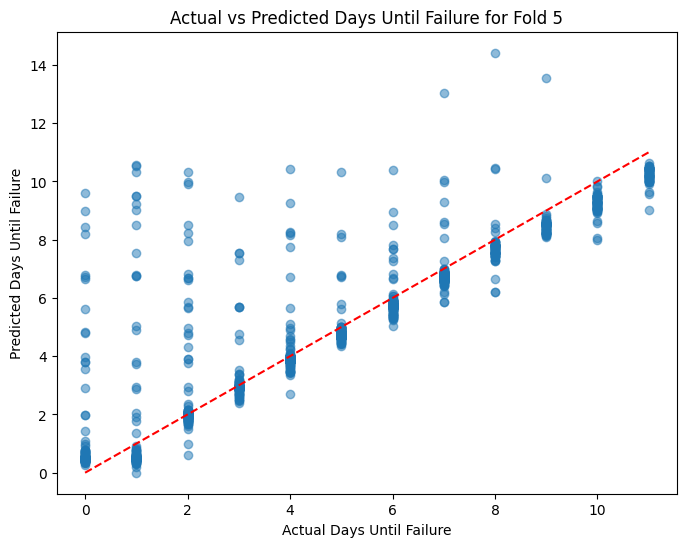

--------------------------------

Average MAE across folds: 0.56
Average RMSE across folds: 1.19


: 

In [ ]:
# Retrieve the best learning rate
best_learning_rate = study.best_trial.params['lr']
print(f"Best learning rate found: {best_learning_rate}")

# Now, retrain the model using the best learning rate and perform K-fold cross-validation
learning_rate = best_learning_rate

# Prepare K-fold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# For storing the results
results = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'\nFold {fold + 1}/{k_folds}')
    
    # Create data loaders for training and validation
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
    
    # Initialize the model
    model = FullyConnectedNet(input_size).to(device)
    
    # Define loss and optimizer with the best learning rate
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    # Evaluation on the validation set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(batch_y.cpu().numpy().flatten())
    
    # Compute MAE and RMSE
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    print(f'Validation MAE for fold {fold + 1}: {mae:.2f}')
    print(f'Validation RMSE for fold {fold + 1}: {rmse:.2f}')
    results[fold] = {'MAE': mae, 'RMSE': rmse}
    
    # Plot Actual vs Predicted Days Until Failure
    plt.figure(figsize=(8, 6))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.xlabel('Actual Days Until Failure')
    plt.ylabel('Predicted Days Until Failure')
    plt.title(f'Actual vs Predicted Days Until Failure for Fold {fold + 1}')
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # Line y=x
    plt.show()
    
    print('--------------------------------')

# Compute average MAE and RMSE across folds
avg_mae = np.mean([results[fold]['MAE'] for fold in results])
avg_rmse = np.mean([results[fold]['RMSE'] for fold in results])
print(f'\nAverage MAE across folds: {avg_mae:.2f}')
print(f'Average RMSE across folds: {avg_rmse:.2f}')

# ================================================